# Homework 3 - Question 1 - Luke Arend

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from hw3.unknownSystemsAll import unknown_systems as us
neuron1 = us.unknown_system_1
neuron2 = us.unknown_system_2
neuron3 = us.unknown_system_3

You are trying to experimentally characterize three auditory
neurons, in terms of their responses to sounds. For purposes of this problem, the responses of
these neurons are embodied in compiled matlab functions `unknownSystemX.p` with $X = 1, 2,
3$. If you are using Python, import the unknown systems module from the obfuscated Python
file. Each takes an input column vector of length $N = 64$ whose elements represent sound
pressure over time. In Python the response of each is a column vector (of the same length)
representing the mean spike count over time. For each neuron,

# a)

“Kick the tires” by measuring the response to an impulse in the first position of an input vector. Check that the system is consistent with shift-invariance by comparing this to the response to an impulse at positions $n = 2, 4, 8$. Check that the system is consistent with linearity by asserting that the response to any combination of two impulses is equal to the sum of their individual responses. Also examine respones to impulses at different n to determine how the system handles inputs near the boundary (i.e., whether the system does circular boundary-handling). Describe your findings.

In [2]:
def unit_impulse(idx=0):
    """ Produce a length-64 zero vector with a 1 at position `idx`. """
    signal = np.zeros(64)
    signal[idx] = 1
    return signal

In [73]:
def plot_impulse_response(system, positions=(0, 1, 3, 7)):
    """ Plot the system's response to up to four unit impulses. """
    fig, axs = plt.subplots(2, 2)
    for i, pos in enumerate(positions):
        plt.sca(axs.flat[i])
        impulse = unit_impulse(idx=pos)
        response = pd.Series(system(impulse))
        plt.title(f'Impulse(t={pos})')
        sns.lineplot(impulse, label='Input')
        sns.lineplot(response, label='Response')
        plt.legend()
        if i % 2 == 0:
            plt.ylabel('Mean spike count')
        if i >= 2:
            plt.xlabel('Time step')
    plt.tight_layout()

In [4]:
def obeys_shift_invariance(system):
    """ Return True if the system's response to a unit impulse at time t
    equals its response to the unit impulse at time 0 shifted by t. """
    response_0 = system(unit_impulse(0))
    for i in range(1, 64):
        response = system(unit_impulse(idx=i))
        shifted = np.concatenate([response[i:], response[:i]])
        if not np.allclose(shifted, response_0):
            return False
    return True

In [5]:
response = neuron1(unit_impulse(idx=3))

In [6]:
def obeys_linear_superposition(system):
    """ Return True if the system's response to a sum of any two
    impulses equals the sum of its responses to each impulse. """
    for i in range(64):
        for j in range(64):
            signal1 = unit_impulse(i)
            signal2 = unit_impulse(j)
            response1 = system(signal1)
            response2 = system(signal2)
            response3 = system(signal1 + signal2)
            if not np.allclose(response1 + response2, response3):
                return False
    return True

### Neuron 1

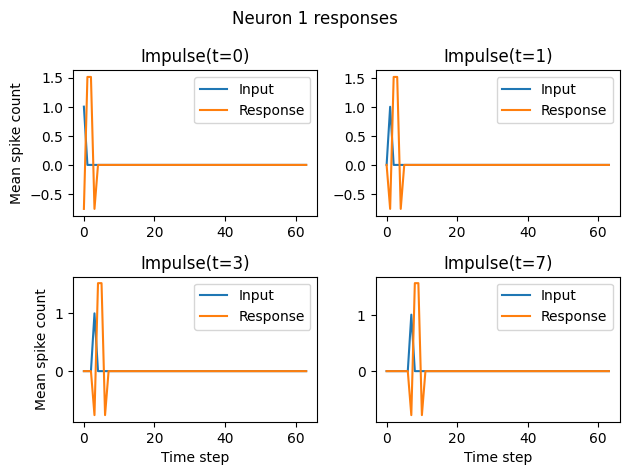

In [74]:
plot_impulse_response(neuron1, positions=[0, 1, 3, 7])
plt.suptitle(f'Neuron 1 responses')
plt.tight_layout()

Neuron 1 might seem shift-invariant if you check its responses to step functions in the first few time steps. But compare unit functions at `t=0` and `t=32`:

In [8]:
response1 = neuron1(unit_impulse(0))
response2 = neuron1(unit_impulse(32))
np.max(response1), np.max(response2)

(1.5099980968844182, 2.4000000000000004)

In [9]:
obeys_shift_invariance(neuron1)

False

The responses to an impulse function changes amplitude as we shift the input in time. So Neuron 1 **is not shift-invariant**.

In [10]:
obeys_linear_superposition(neuron1)

True

Neuron 1 **is linear** in that its response obeys linear superposition.

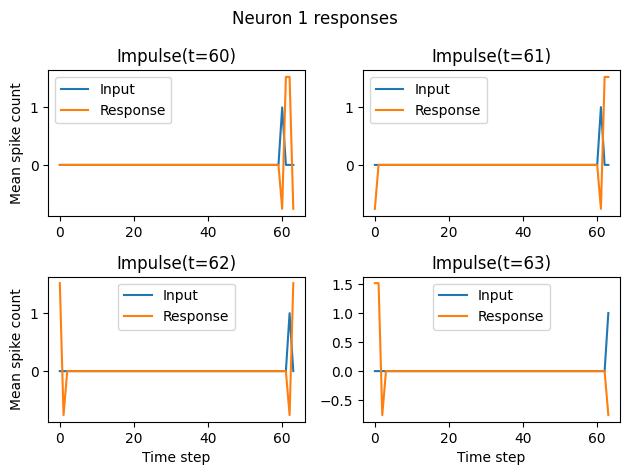

In [75]:
plot_impulse_response(neuron1, positions=[60, 61, 62, 63])
plt.suptitle(f'Neuron 1 responses')
plt.tight_layout()

The response to impulses at timesteps `t = [60, 61, 62, 63]` shows that Neuron 1 **does circular boundary-handling** (it views the end of its input range as wrapping around to connect with the beginning).

### Neuron 2

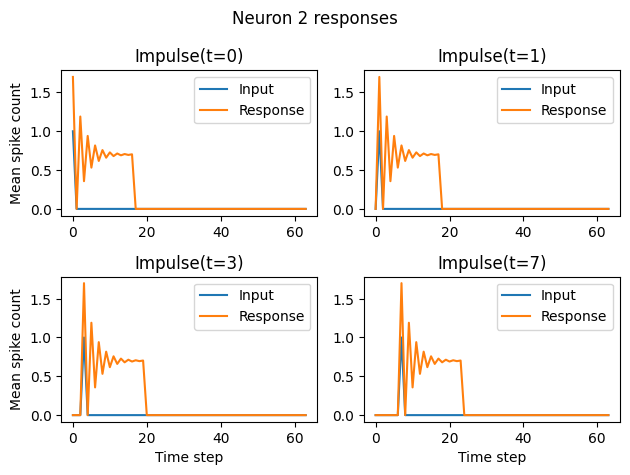

In [76]:
plot_impulse_response(neuron2, positions=[0, 1, 3, 7])
plt.suptitle(f'Neuron 2 responses')
plt.tight_layout()

In [77]:
obeys_shift_invariance(neuron2)

True

Neuron 2 **is shift-invariant** in that the response to an impulse function only shifts (and does not change otherwise) as we shift the input in time.

In [78]:
obeys_linear_superposition(neuron2)

True

Neuron 2 **is linear** in that its response obeys linear superposition.

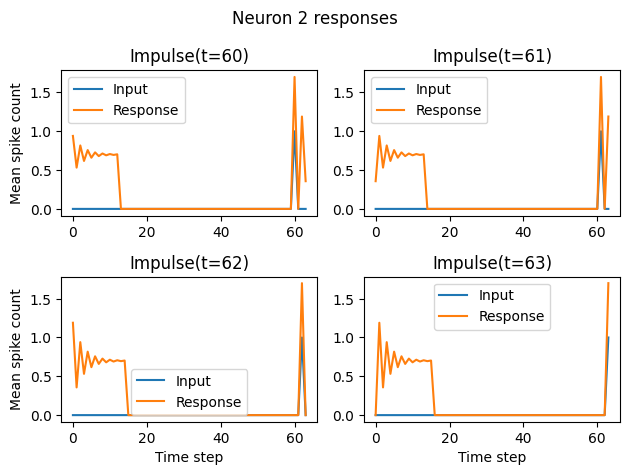

In [79]:
plot_impulse_response(neuron2, positions=[60, 61, 62, 63])
plt.suptitle(f'Neuron 2 responses')
plt.tight_layout()

The response to impulses at timesteps `t = [60, 61, 62, 63]` shows that Neuron 2 **does circular boundary-handling**.

### Neuron 3

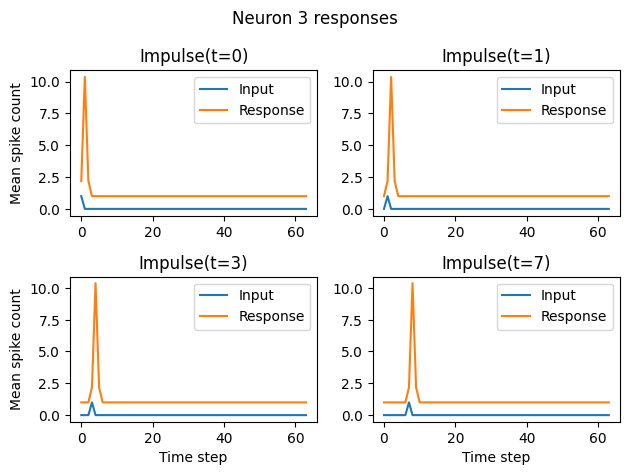

In [80]:
plot_impulse_response(neuron3, positions=[0, 1, 3, 7])
plt.suptitle(f'Neuron 3 responses')
plt.tight_layout()

In [81]:
obeys_shift_invariance(neuron3)

True

Neuron 3 **is shift-invariant** in that its response to an impulse function merely shifts as we shift the input in time.

In [82]:
obeys_linear_superposition(neuron3)

False

Neuron 3 **is not linear** as its response does not obey linear superposition.

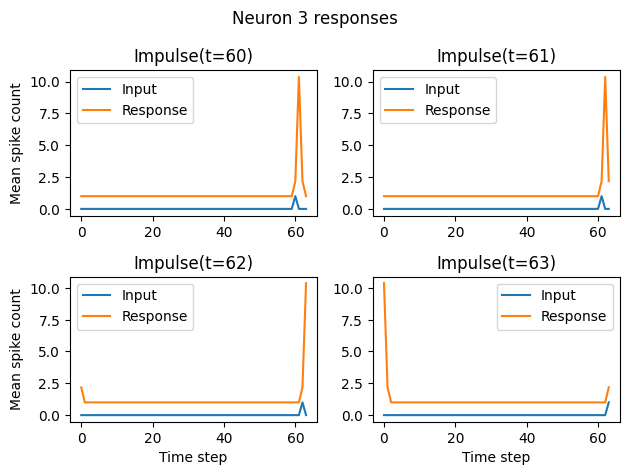

In [83]:
plot_impulse_response(neuron3, positions=[60, 61, 62, 63])
plt.suptitle(f'Neuron 3 responses')
plt.tight_layout()

The response to impulses at timesteps `t = [60, 61, 62, 63]` shows that Neuron 3 **does circular boundary-handling**.

# b)

If the previous tests succeeded, examine the response of the system to sinusoids with frequencies ${2π/N, 4π/N, 8π/N, 16π/N}$, and random phases, and check whether the outputs are sinusoids of the same frequency (i.e., verify that the output vector lies completely in the subspace containing all the sinusoids of that frequency). [Note: make all elements of the the input stimuli positive, by adding one to each sinusoid. The responses will then also be positive (mean spike counts).]

The previous tests indicated that **Neuron 2** was linear and shift-invariant.

In [1]:
s = np.arange(64) / 64
ncycles = [1, 2, 4, 8]
randphase = 2 * np.pi * np.random.rand(4)
sinusoids = np.array([np.sin(n * 2 * np.pi * s + phase)
                      for n, phase in zip(ncycles, randphase)])
responses = [neuron2(x) for x in 1 + sinusoids]

def plot_responses(system, inputs, titles):
    """ Plot up to four inputs and the corresponding system responses. """
    fig, axs = plt.subplots(2, 2)
    for i, signal in enumerate(inputs):
        plt.sca(axs.flat[i])
        plt.title(titles[i])
        sns.lineplot(signal, label='Input')
        sns.lineplot(system(signal), label='Response')
        plt.legend()
        if i % 2 == 0:
            plt.ylabel('Mean spike count')
        if i >= 2:
            plt.xlabel('Time step')
    plt.tight_layout()

NameError: name 'np' is not defined

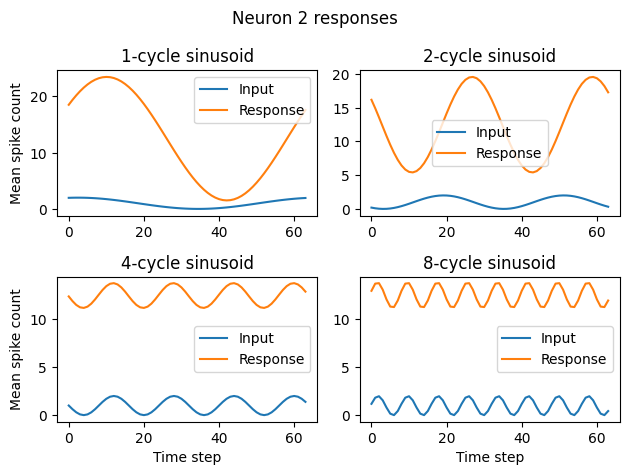

In [113]:
titles = [f'{n}-cycle sinusoid' for n in ncycles]
plot_responses(neuron2, 1 + sinusoids, titles=titles)
plt.suptitle(f'Neuron 2 responses')
plt.tight_layout()

In [144]:
x = sinusoids[0]
y = neuron2(x)

In [159]:
s = 2 * np.pi * np.arange(64) / 64
v = np.sin(s) - 1j * np.cos(s)

In [160]:
x @ v

(7.723519329628845-31.053940960284727j)

In [161]:
y @ v

(293.68650100385275-192.82542760823003j)

# c)

If the previous tests succeeded, verify that the change in amplitude and phase from input to output is predicted by the amplitude (abs) and phase (angle) of the corresponding terms of the Fourier transform of the impulse response. If not, explain which property (linearity, or shift-invariance, or both) seems to be violated by the system. If so, does the combination of all of your tests guarantee that the system is linear and shift-invariant? What set of tests would provide such a guarantee?